## Librerias

In [22]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from google.cloud import bigquery
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')

## Parametros

In [2]:
# Datos de las tablas a traer
proyecto = 'co-keralty-costomedico'
dataset = 'Diabetes_avicena_new'

# Nombres de tablas disponibles en el dataset
tables = ['diabetes', 'examenes_por_usuarios','antecedentes_x_usuario','perimetros_x_usuarios','actividadFisica_x_usuarios','diabetes_copy']

client_bq = bigquery.Client(project= proyecto)


tipo_identificacion = {
    'Cédula de ciudadanía' : 0,
    'Tarjeta de identidad' : 1,
    'Cédula de extranjería' : 2,
    'Permiso por Protección Temporal' : 3,
    'Pasaporte' : 4,
    'Permiso Especial de Permanencia' : 5,
    'Salvo Conducto de Permanencia' : 6,
}

nivel_academico = {
    'Básica secundaria' : 0,
    'Básica primaria' : 1,
    'Normalista' : 2,
    'Ninguno' : 3,
    'Profesional' : 4,
    'Técnica profesional' : 5,
    'Preescolar' : 6,
    'Bachillerato técnico' : 7,
    'Media académica o clásica' : 8,
    'Tecnológica' : 9,
    'Maestría' : 10,
    'Especialización' : 11,
    'Doctorado' : 12,
    'None' : 13,
}

raza_paciente = {
    'Otros' : 0,
    'Mestizo' : 1,
    'Raizales' : 2,
    'Afrocolombiano' : 3,
    'Indígena' : 4,
    'Palenquero' : 5,
    'Rom/Gitano' : 6,
    'None' : 7,
}

ejercicio = {
    '20 minutos\n' : 0,
    '40 minutos\n' : 1,
    'Nunca\n' : 2,
    '60 minutos\n' : 3,
}


## Funciones

### Funciones de carga de datos

In [3]:
def bring_data_from_bq(table, client_bq, query = '', save = False, read_local = False):

    print(f'Leyendo datos de la tabla: {table}')

    if query == '':
        query = f"""SELECT * FROM {proyecto}.{dataset}.{table} WHERE edad >= 18"""

    if read_local:
        data = pd.read_parquet(f'{table}.parquet')
    else:
        data = client_bq.query(query).result().to_dataframe()

        if save:
            data.to_parquet(f'{table}.parquet')
            print(f'Informacion guardada en el archivo: {table}.parquet')

    return data

def prepare_data(data):
    data_new = data.copy()

    campos = [['tipo_identificacion_paciente',tipo_identificacion],['nivel_academico_paciente',nivel_academico],['raza_paciente',raza_paciente],['hace_ejercicio',ejercicio]]

    for tupla in campos:
        data_new[tupla[0]] = data_new[tupla[0]].replace(tupla[1])

    data_new = data_new.drop(columns=['numero_identificacion_paciente','albuminuria']).astype(float)

    return data_new.drop_duplicates()

### Funciones para clusters

In [4]:
def normalize_data(data, variable):
    data_prueba = data[[variable]]

    data_prueba['zscore'] = np.abs(zscore(data_prueba[variable]))
    data_prueba.loc[data_prueba.zscore >= 3,'zscore'] = 'Outlayer'

    data_prueba = data_prueba[data_prueba != 'Outlayer']
    data_prueba.drop(columns = ['zscore'], inplace=True)

    scaler = StandardScaler()
    datos_normalizados = scaler.fit_transform(np.array(data_prueba))

    return datos_normalizados

def elbow_process(datos_normalizados, plot = False):
    
    distortions = []
    inertias = []
    mapping1 = {}
    mapping2 = {}
    K = range(1, 10)

    for k in K:
        # Building and fitting the model
        kmeanModel = KMeans(n_clusters=k).fit(datos_normalizados)
        kmeanModel.fit(datos_normalizados)
    
        distortions.append(sum(np.min(cdist(datos_normalizados, kmeanModel.cluster_centers_,
                                            'euclidean'), axis=1)) / datos_normalizados.shape[0])
        inertias.append(kmeanModel.inertia_)
    
        mapping1[k] = sum(np.min(cdist(datos_normalizados, kmeanModel.cluster_centers_,
                                    'euclidean'), axis=1)) / datos_normalizados.shape[0]
        mapping2[k] = kmeanModel.inertia_

    if plot:
        # for key, val in mapping1.items():
        #     print(f'{key} : {val}')

        plt.plot(K, distortions, 'bx-')
        plt.xlabel('Values of K')
        plt.ylabel('Distortion')
        plt.title('The Elbow Method using Distortion')
        plt.show()

        # for key, val in mapping2.items():
        #     print(f'{key} : {val}')


        plt.plot(K, inertias, 'bx-')
        plt.xlabel('Values of K')
        plt.ylabel('Inertia')
        plt.title('The Elbow Method using Inertia')
        plt.show()

def train_kmeans(data, clusters):
    kmeans = KMeans(n_clusters=clusters, random_state=42, n_init=10)

    kmeans.fit(data) 

    return kmeans

def etiquetar_clusters(data,variable, model, plot = False):

    data_label = data#[[variable]].copy()
    
    cluster_name ='cluster_'+ variable
    data_label[cluster_name] = model.predict(data_label[[variable]])

    if plot:
        # Visualizar la variable 'recency' en función de los clusters
        sns.boxplot(data=data_label, x=cluster_name, y=variable)
        plt.title(f'{variable.upper()} por Clusters CENTROIDE (kmeans)')
        plt.xlabel('Cluster')
        plt.ylabel(variable)
        plt.show()

    return data_label


## Carga de Datos

In [6]:
data_original = bring_data_from_bq(table = tables[0], client_bq = client_bq, save = True, read_local = True)
data = prepare_data(data_original)

data.head(5)

Leyendo datos de la tabla: diabetes


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
0,0.00,64.00,0.00,11001.00,0.00,0.00,57.60,1.50,25.60,58.00,87.43,60.64,0.00,0.00,0.00,0.00,78.00,0.00,0.00
1,0.00,54.00,0.00,54001.00,1.00,0.00,57.60,1.50,25.60,57.00,30.00,374.00,0.00,0.00,0.00,0.00,75.00,0.00,0.00
2,0.00,69.00,0.00,15001.00,2.00,0.00,57.60,1.50,25.60,66.00,171.00,91.00,0.00,0.00,0.00,0.00,89.00,1.00,0.00
3,0.00,57.00,0.00,8001.00,3.00,0.00,57.60,1.50,25.60,39.00,143.00,280.00,0.00,0.00,0.00,0.00,95.00,0.00,1.00
4,0.00,50.00,0.00,19001.00,4.00,0.00,57.60,1.50,25.60,59.00,140.00,186.00,0.00,0.00,0.00,0.00,87.00,0.00,0.00


## Clusters

### Sinteticos

In [9]:
variables_to_iterar = ['edad',
                    #    'codigo_ciudad_sucursal',
                       'imc',
                       'HDL',
                       'LDL',
                       'trigliceridos',
                       'PERIMETRO_ABDOMINAL']

elbow = False

clusters_variables = {
    'edad': 3,
    # 'codigo_ciudad_sucursal': 3,
    'imc': 5,
    'HDL': 3,
    'LDL': 2,
    'trigliceridos': 2,
    'PERIMETRO_ABDOMINAL': 4,
}

data_full = data.copy()

for variable in variables_to_iterar:
    print('------------------------------------------------------------------------')
    print(f'Procesando la variable: {variable}')
    print('------------------------------------------------------------------------')

    datos_normalizados = normalize_data(data = data,variable = variable)
    
    if elbow:
        elbow_process(datos_normalizados=datos_normalizados , plot=False)

    model = train_kmeans(data = datos_normalizados, clusters = clusters_variables[variable])

    df_final = etiquetar_clusters(data = data_full,variable = variable, model = model, plot = False)
    

------------------------------------------------------------------------
Procesando la variable: edad
------------------------------------------------------------------------
------------------------------------------------------------------------
Procesando la variable: imc
------------------------------------------------------------------------
------------------------------------------------------------------------
Procesando la variable: HDL
------------------------------------------------------------------------
------------------------------------------------------------------------
Procesando la variable: LDL
------------------------------------------------------------------------
------------------------------------------------------------------------
Procesando la variable: trigliceridos
------------------------------------------------------------------------
------------------------------------------------------------------------
Procesando la variable: PERIMETRO_ABDOMINAL
--

In [15]:
df_final

,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,...,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes,cluster_edad,cluster_imc,cluster_HDL,cluster_LDL,cluster_trigliceridos,cluster_PERIMETRO_ABDOMINAL
0,0.00,64.00,0.00,11001.00,0.00,0.00,57.60,1.50,25.60,58.00,...,0.00,78.00,0.00,0.00,2,4,2,0,0,2
1,0.00,54.00,0.00,54001.00,1.00,0.00,57.60,1.50,25.60,57.00,...,0.00,75.00,0.00,0.00,2,4,2,0,1,2
2,0.00,69.00,0.00,15001.00,2.00,0.00,57.60,1.50,25.60,66.00,...,0.00,89.00,1.00,0.00,2,4,2,1,0,2
3,0.00,57.00,0.00,8001.00,3.00,0.00,57.60,1.50,25.60,39.00,...,0.00,95.00,0.00,1.00,2,4,2,0,1,2
4,0.00,50.00,0.00,19001.00,4.00,0.00,57.60,1.50,25.60,59.00,...,0.00,87.00,0.00,0.00,2,4,2,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292531,0.00,86.00,0.00,11001.00,0.00,0.00,68.50,1.42,33.97,33.40,...,0.00,95.00,2.00,0.00,2,4,2,0,0,2
292532,0.00,71.00,0.00,68001.00,1.00,0.00,68.50,1.42,33.97,30.30,...,0.00,100.00,1.00,1.00,2,4,2,1,0,2
292533,0.00,71.00,0.00,68001.00,1.00,0.00,68.50,1.42,33.97,30.30,...,0.00,100.00,0.00,1.00,2,4,2,1,0,2
292534,0.00,64.00,0.00,11001.00,8.00,0.00,68.90,1.49,31.03,71.60,...,0.00,103.00,2.00,0.00,2,4,2,0,0,2


In [17]:
variables_to_train = ['cluster_edad',
                      'genero',
                    #   'cluster_codigo_ciudad_sucursal',
                      'cluster_imc',
                      'cluster_HDL',
                      'cluster_LDL',
                      'cluster_trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'cluster_PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'nivel_academico_paciente',
                      'raza_paciente',
                      'diabetes']

df_to_train = df_final[variables_to_train].copy().dropna()
# df_to_train = data[variables_to_train].copy()
df_to_train

,cluster_edad,genero,cluster_imc,cluster_HDL,cluster_LDL,cluster_trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,cluster_PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente,raza_paciente,diabetes
0,2,0.00,4,2,0,0,0.00,0.00,0.00,0.00,2,0.00,0.00,0.00,0.00
1,2,0.00,4,2,0,1,0.00,0.00,0.00,0.00,2,0.00,1.00,0.00,0.00
2,2,0.00,4,2,1,0,0.00,0.00,0.00,0.00,2,1.00,2.00,0.00,0.00
3,2,0.00,4,2,0,1,0.00,0.00,0.00,0.00,2,0.00,3.00,0.00,1.00
4,2,0.00,4,2,0,0,0.00,0.00,0.00,0.00,2,0.00,4.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292531,2,0.00,4,2,0,0,1.00,0.00,1.00,0.00,2,2.00,0.00,0.00,0.00
292532,2,0.00,4,2,1,0,1.00,0.00,1.00,0.00,2,1.00,1.00,0.00,1.00
292533,2,0.00,4,2,1,0,1.00,0.00,1.00,0.00,2,0.00,1.00,0.00,1.00
292534,2,0.00,4,2,0,0,1.00,0.00,1.00,0.00,2,2.00,8.00,0.00,0.00


In [18]:
X = df_to_train[variables_to_train[:-1]]
y = df_to_train[variables_to_train[-1]]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [19]:
lineal_model = LinearRegression()

lineal_model.fit(X_train,y_train)

LinearRegression()

In [20]:
lineal_model.score(X_test,y_test)

0.049999874549844225

In [24]:
model = RandomForestClassifier(n_estimators=20)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

metrica = round(model.score(X_test, y_test)*100,2)
f1 = f1_score(y_test, y_pred)

dict_sex = {0 : 'Mujeres', 1: 'Hombres'}

print(f'Modelo entrenado con una precision de: {metrica}')
print(f'Modelo entrenado con f1 de: {f1}')

Modelo entrenado con una precision de: 70.26
Modelo entrenado con f1 de: 0.1256394640682095


### Medicos

In [45]:
## Pesos Manuales

def peso_edad(value):
    if value < 45:
        return 0
    elif value < 54:
        return 1
    elif value <= 64:
        return 2
    else:
        return 3

def peso_imc(value):
    if value < 30:
        return 0
    elif value < 35:
        return 1
    elif value < 40:
        return 2
    else:
        return 3

def peso_pa(value, gender):

    if gender == 0:
        if value < 90:
            return 0
        elif value < 95:
            return 1
        else:
            return 2
    else:
        if value < 94:
            return 0
        elif value < 100:
            return 1
        else:
            return 2

def peso_ejercicio(value):
    if value == 2:
        return 2
    else:
        return 0

def peso_var_bivalente(value):
    if value == 1:
        return 2
    else:
        return 0

def peso_HDL(value):
    if value < 40:
        return 2
    elif value < 60:
        return 1
    else:
        return 0

def peso_LDL(value):
    if value < 130:
        return 0
    elif value < 160:
        return 1
    elif value < 190:
        return 2
    else:
        return 3

def peso_trigliceridos(value):
    if value < 150:
        return 0
    elif value < 200:
        return 1
    elif value < 500:
        return 2
    else:
        return 3

dict_variables = {
    'edad' : peso_edad,
    'imc' : peso_imc,
    'PERIMETRO_ABDOMINAL' : peso_pa,
    'hace_ejercicio' : peso_ejercicio,
    'med_hipertension' : peso_var_bivalente,
    'familiar_dm' : peso_var_bivalente,
    'HDL' : peso_HDL,
    'LDL' : peso_LDL,
    'trigliceridos' : peso_trigliceridos,
    'ant_cardiovascular' : peso_var_bivalente,
    'dm_gestacional' : peso_var_bivalente,
}

list(dict_variables.keys())

['edad',
 'imc',
 'PERIMETRO_ABDOMINAL',
 'hace_ejercicio',
 'med_hipertension',
 'familiar_dm',
 'HDL',
 'LDL',
 'trigliceridos',
 'ant_cardiovascular',
 'dm_gestacional']

In [47]:
genero = 1
data_prueba = data[data.genero == genero].copy()

In [48]:
for key in dict_variables:
    if key == 'PERIMETRO_ABDOMINAL':
        data_prueba[key] = data_prueba[key].map(lambda x: dict_variables[key](x, genero))
    else:
        data_prueba[key] = data_prueba[key].map(lambda x: dict_variables[key](x))

data_prueba = data_prueba.dropna()

data_prueba

,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
6,0.00,1,1.00,41001.00,0.00,0.00,101.00,1.68,2,2,1,2,0,0,0,0,2,2,0.00
7,0.00,0,1.00,19001.00,0.00,1.00,101.00,1.68,2,1,0,0,0,0,0,0,2,2,0.00
24,1.00,0,1.00,20001.00,1.00,0.00,51.00,1.64,0,1,0,0,0,0,0,0,0,2,0.00
25,0.00,3,1.00,8758.00,3.00,0.00,83.30,1.75,0,1,0,1,0,0,0,0,1,0,0.00
105,0.00,1,1.00,19001.00,0.00,0.00,88.20,1.75,0,2,0,0,0,0,0,0,2,2,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292523,0.00,2,1.00,11001.00,2.00,0.00,94.60,1.73,1,1,0,2,2,0,2,0,2,2,0.00
292524,0.00,1,1.00,5001.00,0.00,0.00,94.60,1.73,1,1,2,2,2,0,2,0,2,0,0.00
292525,0.00,3,1.00,25307.00,3.00,0.00,94.60,1.73,1,1,0,0,2,0,2,0,2,2,1.00
292527,0.00,2,1.00,8001.00,5.00,0.00,99.10,1.81,1,1,0,0,2,0,2,0,1,0,0.00


In [49]:
## Sampleo manual

df = data[data.diabetes == 1]
sample = data[data.diabetes == 0].sample(len(df))

df = pd.concat([df,sample])
df

,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
3,0.00,57.00,0.00,8001.00,3.00,0.00,57.60,1.50,25.60,39.00,143.00,280.00,0.00,0.00,0.00,0.00,95.00,0.00,1.00
11,0.00,43.00,0.00,50001.00,0.00,0.00,101.00,1.68,35.79,44.92,121.00,321.00,0.00,0.00,0.00,1.00,126.00,2.00,1.00
21,0.00,32.00,0.00,11001.00,3.00,0.00,51.00,1.64,18.96,81.00,83.00,34.00,0.00,0.00,0.00,1.00,74.00,0.00,1.00
26,0.00,40.00,0.00,20001.00,4.00,0.00,61.20,1.50,27.20,51.00,125.00,87.00,0.00,0.00,0.00,0.00,70.00,2.00,1.00
31,0.00,40.00,0.00,20001.00,4.00,0.00,61.20,1.50,27.20,51.00,125.00,87.00,0.00,0.00,0.00,0.00,70.00,1.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192914,0.00,54.00,0.00,8001.00,0.00,0.00,88.00,1.58,35.25,44.00,100.90,224.00,1.00,0.00,1.00,0.00,103.00,0.00,0.00
146236,0.00,80.00,1.00,19001.00,0.00,0.00,94.00,1.72,31.77,35.90,87.00,118.10,1.00,0.00,1.00,0.00,109.00,0.00,0.00
239524,0.00,71.00,0.00,76001.00,3.00,0.00,65.00,1.52,28.13,62.00,163.00,129.00,1.00,0.00,1.00,0.00,95.00,2.00,0.00
79658,0.00,76.00,1.00,25175.00,3.00,0.00,64.00,1.60,25.00,61.80,112.68,101.53,1.00,0.00,1.00,0.00,90.00,0.00,0.00


In [50]:
genero = 0
data_prueba = df[df.genero == genero].copy()

for key in dict_variables:
    if key == 'PERIMETRO_ABDOMINAL':
        data_prueba[key] = data_prueba[key].map(lambda x: dict_variables[key](x, genero))
    else:
        data_prueba[key] = data_prueba[key].map(lambda x: dict_variables[key](x))

data_prueba = data_prueba.dropna()
data_prueba['diabetes_peso'] = data_prueba[list(dict_variables.keys())].sum(axis = 1)
display(data_prueba)

data_prueba

variables_to_train = ['edad',
                      'genero',
                      'codigo_ciudad_sucursal',
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'nivel_academico_paciente',
                      'raza_paciente',
                      'diabetes']

# df_to_train = df_final[variables_to_train].copy()
df_to_train = data_prueba[variables_to_train].copy()
df_to_train

X = df_to_train[variables_to_train[:-1]]
y = df_to_train[variables_to_train[-1]]
y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

lineal_model = LinearRegression()

lineal_model.fit(X_train,y_train)

lineal_model.score(X_test,y_test)

,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes,diabetes_peso
3,0.00,2,0.00,8001.00,3.00,0.00,57.60,1.50,0,2,1,2,0,0,0,0,2,0,1.00,9
11,0.00,0,0.00,50001.00,0.00,0.00,101.00,1.68,2,1,0,2,0,0,0,2,2,2,1.00,11
21,0.00,0,0.00,11001.00,3.00,0.00,51.00,1.64,0,0,0,0,0,0,0,2,0,0,1.00,2
26,0.00,0,0.00,20001.00,4.00,0.00,61.20,1.50,0,1,0,0,0,0,0,0,0,2,1.00,3
31,0.00,0,0.00,20001.00,4.00,0.00,61.20,1.50,0,1,0,0,0,0,0,0,0,0,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200436,0.00,2,0.00,8001.00,0.00,0.00,75.90,1.59,1,1,0,0,2,0,2,0,2,0,0.00,10
10159,0.00,1,0.00,13001.00,3.00,0.00,117.80,1.66,3,1,0,0,0,0,0,0,2,2,0.00,9
192914,0.00,2,0.00,8001.00,0.00,0.00,88.00,1.58,2,1,0,2,2,0,2,0,2,0,0.00,13
239524,0.00,3,0.00,76001.00,3.00,0.00,65.00,1.52,0,0,2,0,2,0,2,0,2,2,0.00,13


0.14712390036126477

In [51]:
genero = 1
data_prueba = data[data.genero == genero].copy()

for key in dict_variables:
    if key == 'PERIMETRO_ABDOMINAL':
        data_prueba[key] = data_prueba[key].map(lambda x: dict_variables[key](x, genero))
    else:
        data_prueba[key] = data_prueba[key].map(lambda x: dict_variables[key](x))

data_prueba = data_prueba.dropna()
data_prueba['diabetes_peso'] = data_prueba[list(dict_variables.keys())].sum(axis = 1)
display(data_prueba)

data_prueba

variables_to_train = ['edad',
                    #   'genero',
                      'codigo_ciudad_sucursal',
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'nivel_academico_paciente',
                      'raza_paciente',
                      'diabetes']

# df_to_train = df_final[variables_to_train].copy()
df_to_train = data_prueba[variables_to_train].copy()
df_to_train

X = df_to_train[variables_to_train[:-1]]
y = df_to_train[variables_to_train[-1]]
y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

lineal_model = LinearRegression()

lineal_model.fit(X_train,y_train)

lineal_model.score(X_test,y_test)

,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes,diabetes_peso
6,0.00,1,1.00,41001.00,0.00,0.00,101.00,1.68,2,2,1,2,0,0,0,0,2,2,0.00,12
7,0.00,0,1.00,19001.00,0.00,1.00,101.00,1.68,2,1,0,0,0,0,0,0,2,2,0.00,7
24,1.00,0,1.00,20001.00,1.00,0.00,51.00,1.64,0,1,0,0,0,0,0,0,0,2,0.00,3
25,0.00,3,1.00,8758.00,3.00,0.00,83.30,1.75,0,1,0,1,0,0,0,0,1,0,0.00,6
105,0.00,1,1.00,19001.00,0.00,0.00,88.20,1.75,0,2,0,0,0,0,0,0,2,2,0.00,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292523,0.00,2,1.00,11001.00,2.00,0.00,94.60,1.73,1,1,0,2,2,0,2,0,2,2,0.00,14
292524,0.00,1,1.00,5001.00,0.00,0.00,94.60,1.73,1,1,2,2,2,0,2,0,2,0,0.00,13
292525,0.00,3,1.00,25307.00,3.00,0.00,94.60,1.73,1,1,0,0,2,0,2,0,2,2,1.00,13
292527,0.00,2,1.00,8001.00,5.00,0.00,99.10,1.81,1,1,0,0,2,0,2,0,1,0,0.00,9


0.07310034744515681

In [52]:
genero = 1
data_prueba = data[data.genero == genero].copy()

for key in dict_variables:
    if key == 'PERIMETRO_ABDOMINAL':
        data_prueba[key] = data_prueba[key].map(lambda x: dict_variables[key](x, genero))
    else:
        data_prueba[key] = data_prueba[key].map(lambda x: dict_variables[key](x))

data_prueba = data_prueba.dropna()
data_prueba['diabetes_peso'] = data_prueba[list(dict_variables.keys())].sum(axis = 1)
display(data_prueba)

data_prueba

variables_to_train = ['edad',
                    #   'genero',
                      'codigo_ciudad_sucursal',
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'nivel_academico_paciente',
                      'raza_paciente',
                      'diabetes']

# df_to_train = df_final[variables_to_train].copy()
df_to_train = data_prueba[variables_to_train].copy()
df_to_train

X = df_to_train[variables_to_train[:-1]]
y = df_to_train[variables_to_train[-1]]
y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)


model = RandomForestClassifier(n_estimators=20)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

metrica = round(model.score(X_test, y_test)*100,2)
f1 = f1_score(y_test, y_pred)

dict_sex = {0 : 'Mujeres', 1: 'Hombres'}

print(f'Modelo de {dict_sex[genero]} entrenado con una precision de: {metrica}')
print(f'Modelo de {dict_sex[genero]} entrenado con f1 de: {f1}')

,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes,diabetes_peso
6,0.00,1,1.00,41001.00,0.00,0.00,101.00,1.68,2,2,1,2,0,0,0,0,2,2,0.00,12
7,0.00,0,1.00,19001.00,0.00,1.00,101.00,1.68,2,1,0,0,0,0,0,0,2,2,0.00,7
24,1.00,0,1.00,20001.00,1.00,0.00,51.00,1.64,0,1,0,0,0,0,0,0,0,2,0.00,3
25,0.00,3,1.00,8758.00,3.00,0.00,83.30,1.75,0,1,0,1,0,0,0,0,1,0,0.00,6
105,0.00,1,1.00,19001.00,0.00,0.00,88.20,1.75,0,2,0,0,0,0,0,0,2,2,0.00,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292523,0.00,2,1.00,11001.00,2.00,0.00,94.60,1.73,1,1,0,2,2,0,2,0,2,2,0.00,14
292524,0.00,1,1.00,5001.00,0.00,0.00,94.60,1.73,1,1,2,2,2,0,2,0,2,0,0.00,13
292525,0.00,3,1.00,25307.00,3.00,0.00,94.60,1.73,1,1,0,0,2,0,2,0,2,2,1.00,13
292527,0.00,2,1.00,8001.00,5.00,0.00,99.10,1.81,1,1,0,0,2,0,2,0,1,0,0.00,9


Modelo de Hombres entrenado con una precision de: 66.14
Modelo de Hombres entrenado con f1 de: 0.43063767852269624


In [53]:
genero = 0
data_prueba = df[df.genero == genero].copy()

for key in dict_variables:
    if key == 'PERIMETRO_ABDOMINAL':
        data_prueba[key] = data_prueba[key].map(lambda x: dict_variables[key](x, genero))
    else:
        data_prueba[key] = data_prueba[key].map(lambda x: dict_variables[key](x))

data_prueba = data_prueba.dropna()
data_prueba['diabetes_peso'] = data_prueba[list(dict_variables.keys())].sum(axis = 1)
display(data_prueba)

data_prueba

variables_to_train = ['edad',
                    #   'genero',
                      'codigo_ciudad_sucursal',
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'nivel_academico_paciente',
                      'raza_paciente',
                      'diabetes']

# df_to_train = df_final[variables_to_train].copy()
df_to_train = data_prueba[variables_to_train].copy()
df_to_train

X = df_to_train[variables_to_train[:-1]]
y = df_to_train[variables_to_train[-1]]
y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)


model = RandomForestClassifier(n_estimators=20)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

metrica = round(model.score(X_test, y_test)*100,2)
f1 = f1_score(y_test, y_pred)

dict_sex = {0 : 'Mujeres', 1: 'Hombres'}

print(f'Modelo de {dict_sex[genero]} entrenado con una precision de: {metrica}')
print(f'Modelo de {dict_sex[genero]} entrenado con f1 de: {f1}')

,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes,diabetes_peso
3,0.00,2,0.00,8001.00,3.00,0.00,57.60,1.50,0,2,1,2,0,0,0,0,2,0,1.00,9
11,0.00,0,0.00,50001.00,0.00,0.00,101.00,1.68,2,1,0,2,0,0,0,2,2,2,1.00,11
21,0.00,0,0.00,11001.00,3.00,0.00,51.00,1.64,0,0,0,0,0,0,0,2,0,0,1.00,2
26,0.00,0,0.00,20001.00,4.00,0.00,61.20,1.50,0,1,0,0,0,0,0,0,0,2,1.00,3
31,0.00,0,0.00,20001.00,4.00,0.00,61.20,1.50,0,1,0,0,0,0,0,0,0,0,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200436,0.00,2,0.00,8001.00,0.00,0.00,75.90,1.59,1,1,0,0,2,0,2,0,2,0,0.00,10
10159,0.00,1,0.00,13001.00,3.00,0.00,117.80,1.66,3,1,0,0,0,0,0,0,2,2,0.00,9
192914,0.00,2,0.00,8001.00,0.00,0.00,88.00,1.58,2,1,0,2,2,0,2,0,2,0,0.00,13
239524,0.00,3,0.00,76001.00,3.00,0.00,65.00,1.52,0,0,2,0,2,0,2,0,2,2,0.00,13


Modelo de Mujeres entrenado con una precision de: 64.09
Modelo de Mujeres entrenado con f1 de: 0.6222076019019708


In [54]:
data_prueba = df.copy()

for key in dict_variables:
    if key == 'PERIMETRO_ABDOMINAL':
        data_prueba[key] = data_prueba[key].map(lambda x: dict_variables[key](x, genero))
    else:
        data_prueba[key] = data_prueba[key].map(lambda x: dict_variables[key](x))

data_prueba = data_prueba.dropna()
data_prueba['diabetes_peso'] = data_prueba[list(dict_variables.keys())].sum(axis = 1)
display(data_prueba)

data_prueba

variables_to_train = ['edad',
                      'genero',
                      'codigo_ciudad_sucursal',
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'nivel_academico_paciente',
                      'raza_paciente',
                      'diabetes']

# df_to_train = df_final[variables_to_train].copy()
df_to_train = data_prueba[variables_to_train].copy()
df_to_train

X = df_to_train[variables_to_train[:-1]]
y = df_to_train[variables_to_train[-1]]
y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)


model = RandomForestClassifier(n_estimators=20)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

metrica = round(model.score(X_test, y_test)*100,2)
f1 = f1_score(y_test, y_pred)

dict_sex = {0 : 'Mujeres', 1: 'Hombres'}

print(f'Modelo de {dict_sex[genero]} entrenado con una precision de: {metrica}')
print(f'Modelo de {dict_sex[genero]} entrenado con f1 de: {f1}')

,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes,diabetes_peso
3,0.00,2,0.00,8001.00,3.00,0.00,57.60,1.50,0,2,1,2,0,0,0,0,2,0,1.00,9
11,0.00,0,0.00,50001.00,0.00,0.00,101.00,1.68,2,1,0,2,0,0,0,2,2,2,1.00,11
21,0.00,0,0.00,11001.00,3.00,0.00,51.00,1.64,0,0,0,0,0,0,0,2,0,0,1.00,2
26,0.00,0,0.00,20001.00,4.00,0.00,61.20,1.50,0,1,0,0,0,0,0,0,0,2,1.00,3
31,0.00,0,0.00,20001.00,4.00,0.00,61.20,1.50,0,1,0,0,0,0,0,0,0,0,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192914,0.00,2,0.00,8001.00,0.00,0.00,88.00,1.58,2,1,0,2,2,0,2,0,2,0,0.00,13
146236,0.00,3,1.00,19001.00,0.00,0.00,94.00,1.72,1,2,0,0,2,0,2,0,2,0,0.00,12
239524,0.00,3,0.00,76001.00,3.00,0.00,65.00,1.52,0,0,2,0,2,0,2,0,2,2,0.00,13
79658,0.00,3,1.00,25175.00,3.00,0.00,64.00,1.60,0,0,0,0,2,0,2,0,1,0,0.00,8


Modelo de Mujeres entrenado con una precision de: 63.1
Modelo de Mujeres entrenado con f1 de: 0.6338486713143675


Modelo entrenado con una precision de: 69.59
Modelo entrenado con f1 de: 0.41544373867505624


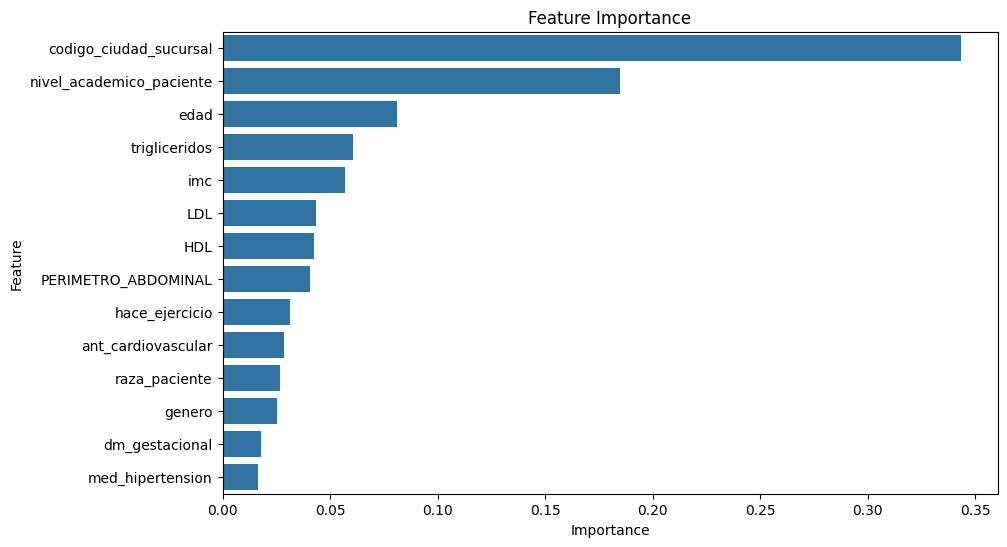

Modelo re-entrenado con una precision de: 68.01
Modelo re-entrenado con f1 de: 0.3702842693421428


In [70]:
data_prueba = data.copy()

for key in dict_variables:
    if key == 'PERIMETRO_ABDOMINAL':
        data_prueba[key] = data_prueba[key].map(lambda x: dict_variables[key](x, genero))
    else:
        data_prueba[key] = data_prueba[key].map(lambda x: dict_variables[key](x))

data_prueba = data_prueba.dropna()
data_prueba['diabetes_peso'] = data_prueba[list(dict_variables.keys())].sum(axis = 1)
# display(data_prueba)

data_prueba

variables_to_train = ['edad',
                      'genero',
                      'codigo_ciudad_sucursal',
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                    #   'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'nivel_academico_paciente',
                      'raza_paciente',
                      'diabetes']

# df_to_train = df_final[variables_to_train].copy()
df_to_train = data_prueba[variables_to_train].copy()
df_to_train

X = df_to_train[variables_to_train[:-1]]
y = df_to_train[variables_to_train[-1]]
y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)


model = RandomForestClassifier(n_estimators=20)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

metrica = round(model.score(X_test, y_test)*100,2)
f1 = f1_score(y_test, y_pred)

dict_sex = {0 : 'Mujeres', 1: 'Hombres'}

print(f'Modelo entrenado con una precision de: {metrica}')
print(f'Modelo entrenado con f1 de: {f1}')


feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()


# Select top 5 features (as an example)
top_features = feature_importance_df.head(10)['Feature'].values

# Create a new dataset with only the top features
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

# Train the classifier with selected features
model = RandomForestClassifier(n_estimators=20)
model.fit(X_train_selected, y_train)

# Make predictions and calculate accuracy after feature selection
y_pred_selected = model.predict(X_test_selected)
# selected_accuracy = accuracy_score(y_test, y_pred_selected)

metrica = round(model.score(X_test_selected, y_test)*100,2)
f1 = f1_score(y_test, y_pred_selected)

print(f'Modelo re-entrenado con una precision de: {metrica}')
print(f'Modelo re-entrenado con f1 de: {f1}')

In [71]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 20,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [25]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [26]:
random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [28]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: 